# [Practical Statistics for Data Scientists](https://www.oreilly.com/library/view/practical-statistics-for/9781491952955/)
by Peter Bruce, Andrew Bruce, & Peter Gedeck

Initialize python environment and import dataset

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sp
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option("display.max.columns", None)
pd.set_option("display.precision", 2)

In [24]:
df = pd.read_csv("data/nba_all_elo.csv", parse_dates=[5],
    dtype={
        "lg_id": "category",
        "_iscopy": "category",
        "seasongame": "category",
        "is_playoffs": "category",
        "team_id": "category",
        "fran_id": "category",
        "opp_id": "category",
        "opp_fran": "category",
        "game_location": "category",
        "game_result": "category"
    }
)
loans_income = pd.read_csv("data/loans_income.csv")

## Chapter 1 - Exploratory Data Analysis

- Inference - set of procedures for drawing conclusions about a large population from small samples.

### Elements of Structured Data

- Data Types
  - Numeric - data expressed on a numeric scale.
    - Continuous - any value between an interval (interval, float, decimal)
    - Discrete - integer values (integer, count)
  - Categorical - can only take specific values (enums, factors, nominal)
    - Binary - 0 or 1, true or false
    - Ordinal - explicit ordering (ordered factor)
    - Categorical types are useful because they tell software how to process the data, allow for better storage and indexing, and enforce valid values.

### Rectangular Data
General term for a two-dimensional matrix with rows and columns. aka a spreadsheet or table.

- Data frame - Standard term for the basic data structure used in statistical and machine learning models.
  - Typically has one or more column that acts as an index.
- Feature - A column within a table (attribute, input, predictor, variable).
- Outcome - Features are somtimes used to predict the outcome of a project. (dependent variable, response, target, output)
- Record - A row within a table (case, example, instance, observation, pattern, sample)

### Nonrectangular Data Structures
These are more specialized structures

- Time series - forcasting data, IoT
- Spatial data structures - spatial coordinates, maps
- Graph (or network)

### Estimates of Location
A "typical value" for each variable (column), an estimate of where most of the data is located.

- Statisticians use the term *estimate* for a value calculated from a data set.
- Data scientists and business analysts use the term *metric*. Which is more concrete and for a practical use.
- Statisticians estimate, data scientists measure.

#### Mean (average)
sum of all values divided by the number of values
- Sensitive to the data (and extreme outliers).
- `values.sum() / values.count()`
- $\bar{x} = \frac{\sum_{i=1}^n x_i}{n}$
- $\bar{x}$ is pronounced "x-bar"

In [4]:
pts = df["pts"]
print("manual:", pts.sum() / pts.count())
print("mean():", pts.mean())

manual: 102.72998242475101
mean(): 102.72998242475101


#### Weighted Mean (weighted average)
sum of all values times a weight divided by the sum of the weights
- Some values are intrinsically more variable than others. These highly variable values should be given lower weights.
  - e.g. A less accurate sensor should be given lower weights.
- The data collected doesn't equally represent the different groups that are being measured.
- `([value] * [weights]).sum() / [weights].sum()`
- $\bar{x}_w = \frac{\sum_{i=1}^n w_i x_i}{\sum_{i=1}^n w_i}$

In [5]:
# add a weight column that weights years less the farther back in time they go
bins = [1900, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2025]
weights = [0.1, 0.2, 0.4, 0.5, 0.7, 0.8, 0.9, 1.0]
df["weight"] = pd.cut(df["year_id"], bins=bins, labels=weights, ordered=False).astype(float)

# calc weighted mean from new weight column
w_mean = (df["pts"] * df["weight"]).sum() / df["weight"].sum()
print("weighted mean pts:" , w_mean)

weighted mean pts: 102.2616841745508


#### Trimmed Mean (truncated mean)
mean after dropping a number of extreme values
- A Mean value that isn't as sensitive to the data and extreme outliers.
- ([values].sort_values()[trim : n - trim]).mean()
- $\bar{x}_{(r)} = \frac{1}{n - 2r} \sum_{i = r+1}^{n-r} x_{(i)}$

In [6]:
pts_sorted = df["pts"].sort_values()
n = len(pts_sorted)
trim = int(0.1 * n) # trim 10%
trimmed = pts_sorted.iloc[trim:n-trim]
print("trimmed mean pts:", trimmed.mean())

# using scipy
print("trimmed with scipy:", sp.trim_mean(df["pts"], 0.1))

trimmed mean pts: 102.71580968214384
trimmed with scipy: 102.71580968214384


#### Median (50th percentile)
The value such that one-half of the data lies above and below
- Less sensitive to the data, less affected by outliers. This is referred to as a *robust* estimate.

In [7]:
print("median:", df["pts"].median())

median: 103.0


#### Weighted Median
The value such that one-half of the sum of the weights lies below and above the sorted data

In [8]:
weights_cs = np.cumsum(df["weight"]) # cumulative sum
cutoff = 0.5 * df["weight"].sum()
median_value = pts_sorted.to_numpy()[weights_cs >= cutoff][0]
print("weighted pts median:", median_value)

weighted pts median: 107


### Estimates of Variability

- Variablity (dispersion) measures whether data values are tightly clustered or spread out.
- Variance and Standard Deviation are the most used statistics on variability. Both are sensitive to outliers.
- More robust metrics are mean absolute deviation, median absolute deviation from the median, and percentiles.

#### Deviations (errors, residuals)
- Difference between the observed value and the estimate of location.

#### Variance (mean-squared-error)
- Sum of the squared deviations from the mean divided by `n - 1` where `n` is the number of values.
- $\frac{\sum_{i=1}^{n} (x_i - \bar{x})^2}{n-1}$
- Not robust

#### Standard deviation
- Square root of the variance
- $\sqrt{ \frac{\sum_{i=1}^{n} (x_i - \bar{x})^2}{n-1}}$
- Not robust

#### Mean absolute deviation (l1-norm, Manhattan norm)
- Mean of the absolute values of the deviations from the mean.
- $\frac{\sum_{i=1}^{n} |x_i - \bar{x}|}{n}$
- Not robust

#### Median absolute deviation from the median (MAD)
- Robust estimate of variability
- (|values - values.median()|).median()
- often scaled by 1.4826 to be comparable to standard deviation in the case of a normal distribution.

#### Range
- Difference between the largest and smallest value.

#### Order statistics (ranks)
- Metrics based on the data values sorted from smallest to biggest

#### Percentile (quantile)
- Value such that *P* percent of the values take on this value or less and (100-P) percent take on this value or more.

#### Interquartile range (IQR)
- The difference between the 75th and 25th percentile.

In [9]:
print("standard deviation:", df["pts"].std())
mad_scaler = 1.4826
mad = (df["pts"] - df["pts"].median()).abs().median() * mad_scaler
print("MAD:", mad)
print("IQR:", df["pts"].quantile(0.75) - df["pts"].quantile(0.25))

standard deviation: 14.81484465438624
MAD: 14.825999999999999
IQR: 19.0


### Exploring the Data Distribution

#### Plot Types

- Boxplot (Box and whiskers) - Quick way to visualize the distribution of data
  - The top and bottom of the box are the 75th and 25the percentiles.
  - The horizontal line in the box is the median.
  - The whiskers extend to the farthest data point up to 1.5 times the IQR.
- Frequency table - Count of values that fall into a set of intervals (`bins`)
- Histogram - Plot of the Frequency table with bins on the x-axis and count on the y-axis. Not the same as a bar chart.
  - Gives a visualization of the data distribution.
- Density plot - Smoothed version of the histogram, often based on a `kernal density estimate`.
  - Area under the density curve = 1

0.05     79.0
0.25     93.0
0.50    103.0
0.75    112.0
0.95    127.0
Name: pts, dtype: float64


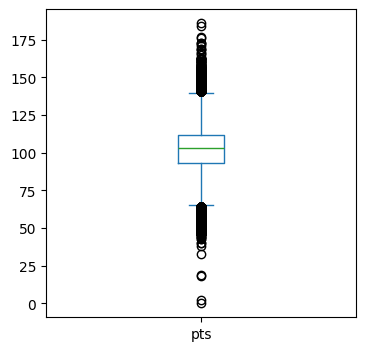

Median: 103.0
IQR: 19.0
75th: 112.0 | top_whisker: 140   | top_threshold: 140.5
25th: 93.0  | bottom_whisker: 65 | bottom_threshold: 64.5


In [10]:
print(df["pts"].quantile([0.05, 0.25, 0.5, 0.75, 0.95]))

# Boxplot
ax = pts.plot.box(figsize=(4,4))
plt.show()
q75 = df["pts"].quantile(0.75)
q25 = df["pts"].quantile(0.25)
iqr = q75 - q25
q75_threshold = q75 + iqr * 1.5
q25_threshold = q25 - iqr * 1.5
q75_closest = df.loc[df["pts"].le(q75_threshold), "pts"].max()
q25_closest = df.loc[df["pts"].ge(q25_threshold), "pts"].min()
print("Median:",pts.median())
print("IQR:", iqr)
print(f"75th: {q75} | top_whisker: {q75_closest}   | top_threshold: {q75_threshold}")
print(f"25th: {q25}  | bottom_whisker: {q25_closest} | bottom_threshold: {q25_threshold}")

In [11]:
# historgram data
pts_bins = pd.cut(df["pts"], 10)
pts_bins.value_counts()

pts
(93.0, 111.6]     59463
(111.6, 130.2]    30107
(74.4, 93.0]      29112
(130.2, 148.8]     3695
(55.8, 74.4]       3531
(148.8, 167.4]      211
(37.2, 55.8]        179
(167.4, 186.0]       11
(-0.186, 18.6]        3
(18.6, 37.2]          2
Name: count, dtype: int64

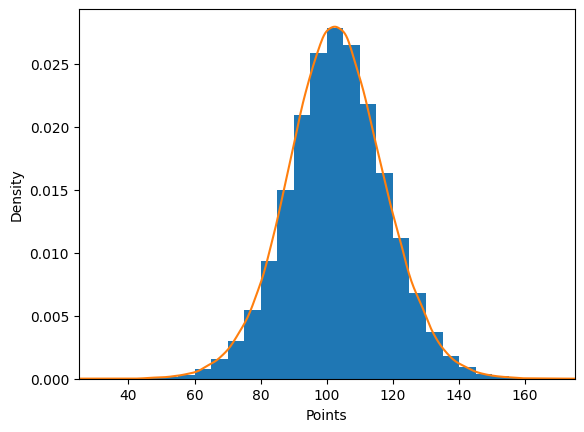

In [12]:
# histogram plot with density plot
ax = df["pts"].plot.hist(density=True, xlim=[25, 175], bins=range(25,175, 5))
df["pts"].plot.density(ax=ax)
ax.set_xlabel("Points")
plt.show()

### Exploring Binary and Categorical Data

- Mode - The most commonly occurring category or value in a data set.
- Expected Value - Average value based on a numeric category's probability of occurrence.
- Bar charts - Frequency or proportion for each category

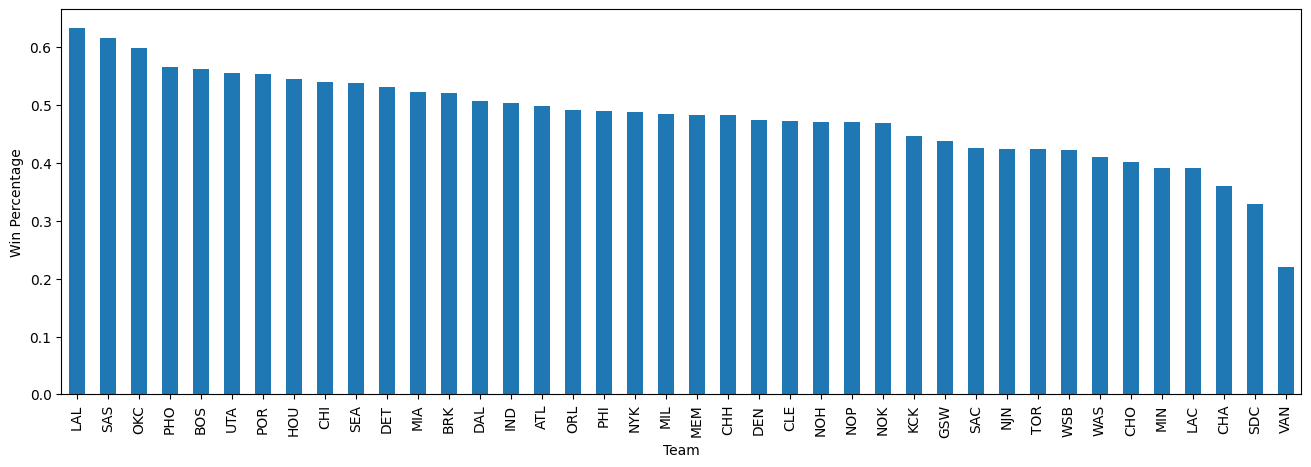

In [13]:
# bar chart of team win percentage since 1980
pivot = (
    df.loc[df["year_id"] > 1980]
      .assign(win=(df["game_result"] == "W").astype(int))  # 1 if win else 0
      .groupby("team_id", as_index=False, observed=True)
      .agg(wins=("win", "sum"), total=("win", "count")) # aggregate wins and total games
      .assign(win_pct=lambda x: x["wins"] / x["total"]) # calc win percentage
      .pivot_table(index=None, columns="team_id", values="win_pct", fill_value=0, observed=True)
)
ax = pivot.transpose().sort_values("win_pct", ascending=False).plot.bar(figsize=(16, 5), legend=False)
ax.set_xlabel("Team")
ax.set_ylabel("Win Percentage")
plt.show()

### Correlation

- Correlation coefficient - A metric that measures the extent to which numeric variables are associated with each other.
  - Pearson's correlation coefficient is the most used standardized correlation coefficient.
  - x's deviation from the mean * y's deviation from the mean / ((n-1) * x and y's standard deviations multiplied together)
  - Pearson's correlation coefficient = $\frac{\sum_{i=1}^{n} (x_i - \bar{x}) (y_i - \bar{y})}{(n-1)s_x s_y}$
- Correlation matrix - A table showing the correlations between variables
- Scatterplot

In [14]:
# SPY and DIA are highly correlated
sp500_sym = pd.read_csv("data/sp500_sectors.csv")
sp500_px = pd.read_csv("data/sp500_data.csv.gz", index_col=0)
etfs = sp500_px.loc[sp500_px.index > '2012-07-01', 
                    sp500_sym[sp500_sym['sector'] == 'etf']['symbol']]
corr = etfs.corr()
corr

,XLI,QQQ,SPY,DIA,GLD,VXX,USO,IWM,XLE,XLY,XLU,XLB,XTL,XLV,XLP,XLF,XLK
XLI,1.00,0.79,0.89,0.87,0.06,-0.47,0.24,0.78,0.65,0.80,0.38,0.78,0.37,0.66,0.60,0.79,0.78
QQQ,0.79,1.00,0.91,0.83,0.04,-0.47,0.20,0.81,0.56,0.84,0.35,0.71,0.42,0.78,0.61,0.75,0.95
SPY,0.89,0.91,1.00,0.95,0.08,-0.55,0.27,0.83,0.71,0.89,0.48,0.83,0.41,0.81,0.74,0.88,0.89
DIA,0.87,0.83,0.95,1.00,0.05,-0.51,0.26,0.76,0.66,0.85,0.46,0.79,0.38,0.77,0.75,0.86,0.84
GLD,0.06,0.04,0.08,0.05,1.00,-0.11,0.22,0.07,0.19,0.02,0.12,0.18,-0.04,-0.01,0.03,0.04,0.05
VXX,-0.47,-0.47,-0.55,-0.51,-0.11,1.00,-0.20,-0.45,-0.45,-0.47,-0.26,-0.47,-0.21,-0.38,-0.42,-0.51,-0.48
USO,0.24,0.20,0.27,0.26,0.22,-0.20,1.00,0.25,0.53,0.18,0.11,0.32,0.08,0.12,0.12,0.22,0.23
IWM,0.78,0.81,0.83,0.76,0.07,-0.45,0.25,1.00,0.59,0.78,0.33,0.70,0.39,0.66,0.54,0.76,0.76
XLE,0.65,0.56,0.71,0.66,0.19,-0.45,0.53,0.59,1.00,0.58,0.34,0.69,0.26,0.45,0.41,0.60,0.56
XLY,0.80,0.84,0.89,0.85,0.02,-0.47,0.18,0.78,0.58,1.00,0.37,0.72,0.37,0.70,0.66,0.78,0.77


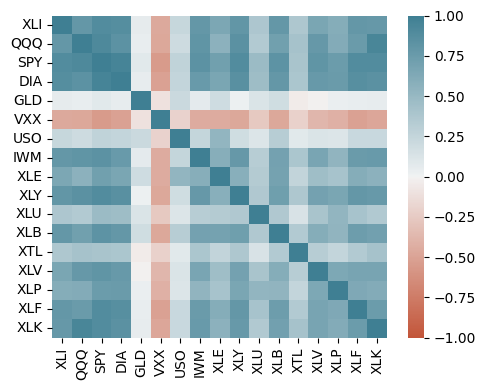

In [15]:
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(corr, vmin=-1, vmax=1, cmap=sns.diverging_palette(20, 220, as_cmap=True), ax=ax)
plt.tight_layout()
plt.show()

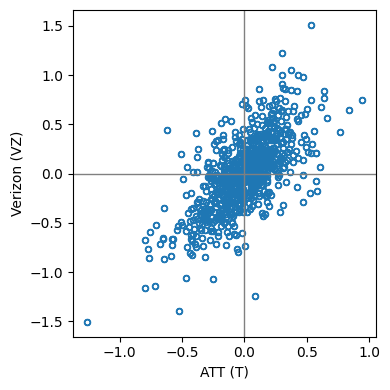

In [16]:
# high correlation visualized in a scatterplot
telecomSymbols = sp500_sym[sp500_sym['sector'] == 'telecommunications_services']['symbol']
telecom = sp500_px.loc[sp500_px.index >= '2012-07-01', telecomSymbols]
ax = telecom.plot.scatter(x='T', y='VZ', figsize=(4, 4), marker='$\u25EF$')
ax.set_xlabel('ATT (T)')
ax.set_ylabel('Verizon (VZ)')
ax.axhline(0, color='grey', lw=1)
ax.axvline(0, color='grey', lw=1)

plt.tight_layout()
plt.show()

### Exploring Two or More Variables
`bivariate analysis` (two variables) or `multivariate analysis` (more than two)

- Contingency table - Counts between two or more categorical variables.
- Hexagonal binning - Plot of two numeric variables with the records binned into hexagons.
  - Good for condensing a lot of data and showing two-dimensional density.
- Contour plot - Similar to hexagonal binning but in a plot like a topographical map.
- Violin plot - Similar to a boxplot but showing density estimates.

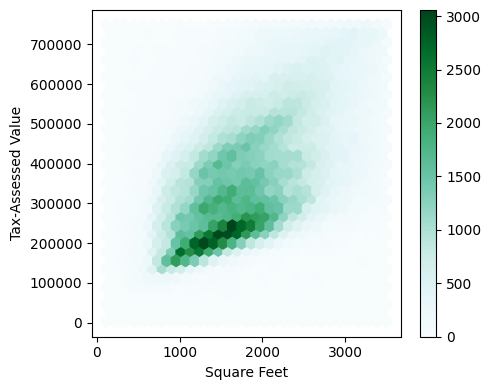

In [17]:
kc_tax = pd.read_csv("data/kc_tax.csv.gz")
kc_tax_filtered = kc_tax.loc[
    (kc_tax.TaxAssessedValue < 750_000) &
    (kc_tax.SqFtTotLiving > 100) &
    (kc_tax.SqFtTotLiving < 3500)]

# hexbin
ax = kc_tax_filtered.plot.hexbin(x='SqFtTotLiving', y='TaxAssessedValue', gridsize=30, sharex=False, figsize=(5,4))
ax.set_xlabel("Square Feet")
ax.set_ylabel("Tax-Assessed Value")
plt.tight_layout()
plt.show()

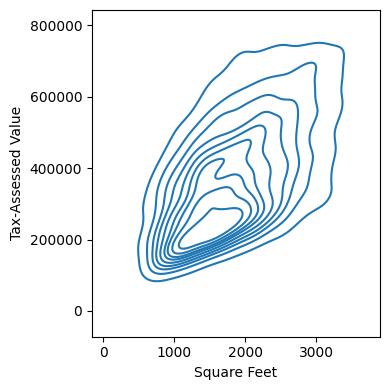

In [18]:
# contour
fig, ax = plt.subplots(figsize=(4, 4))
ax = sns.kdeplot(data=kc_tax_filtered.sample(10000), x="SqFtTotLiving", y="TaxAssessedValue", ax=ax)
ax.set_xlabel("Square Feet")
ax.set_ylabel("Tax-Assessed Value")
plt.tight_layout()
plt.show()

In [19]:
# contingency table
lc_loans = pd.read_csv("data/lc_loans.csv")
crosstab = lc_loans.pivot_table(index='grade', columns='status', aggfunc=lambda x: len(x), margins=True)
df = crosstab.copy().loc['A':'G',:].astype(float)
df.loc[:,'Charged Off':'Late'] = df.loc[:,'Charged Off':'Late'].div(df['All'], axis=0)
df['All'] = df['All'] / sum(df['All'])
perc_crosstab = df
df

status,Charged Off,Current,Fully Paid,Late,All
grade,,,,,
A,0.02,0.69,0.28,6.47e-03,1.61e-01
B,0.04,0.71,0.24,1.55e-02,2.94e-01
C,0.05,0.74,0.19,2.30e-02,2.68e-01
D,0.07,0.72,0.18,3.11e-02,1.65e-01
E,0.08,0.71,0.17,3.95e-02,7.72e-02
F,0.12,0.65,0.18,4.70e-02,2.86e-02
G,0.13,0.61,0.20,6.14e-02,7.19e-03


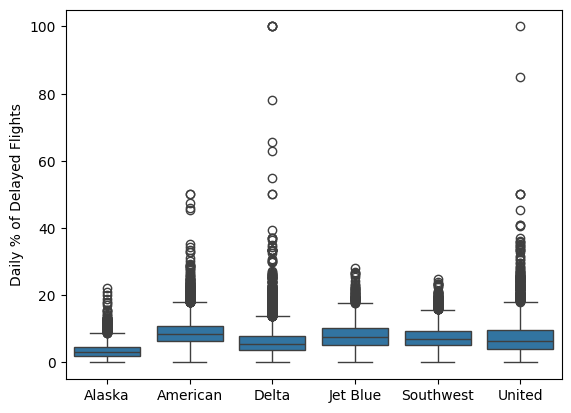

In [20]:
# boxplot
airline_stats = pd.read_csv("data/airline_stats.csv")
airline_order = sorted(airline_stats["airline"].unique())
ax = sns.boxplot(data=airline_stats, x="airline", y="pct_carrier_delay", order=airline_order)
ax.set_xlabel("")
ax.set_ylabel("Daily % of Delayed Flights")
plt.suptitle("")
plt.title("")
plt.show()

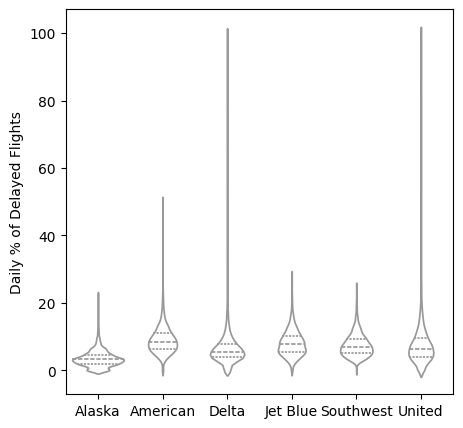

In [21]:
# violin plot
fig, ax = plt.subplots(figsize=(5, 5))
ax = sns.violinplot(data=airline_stats, x="airline", y="pct_carrier_delay", ax=ax, inner="quartile", color="white", order=airline_order)
ax.set_xlabel("")
ax.set_ylabel("Daily % of Delayed Flights")
plt.show()

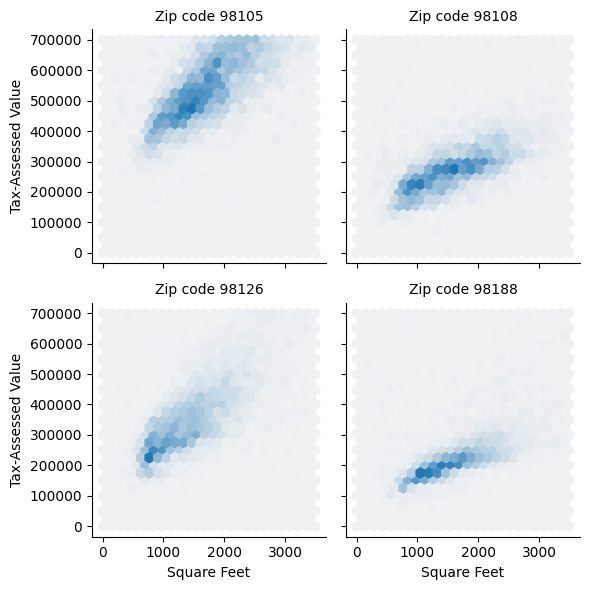

In [22]:
# visualizing multiple variables (kc_tax_filtered by zip code)
zip_codes = [98188, 98105, 98108, 98126]
kc_tax_zip = kc_tax_filtered.loc[kc_tax_filtered.ZipCode.isin(zip_codes)]

def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=25, cmap=cmap, **kwargs)

g = sns.FacetGrid(kc_tax_zip, col="ZipCode", col_wrap=2)
g.map(hexbin, "SqFtTotLiving", "TaxAssessedValue", extent=[0, 3500, 0, 700_000])
g.set_axis_labels("Square Feet", "Tax-Assessed Value")
g.set_titles("Zip code {col_name:.0f}")

## Chapter 2 - Data and Sampling Distributions
Even with massive datasets, sampling remains important because:
- Data can vary in quality and relevance.
- Sampling helps work efficiently and reduce bias.
- Predictive models and tests (e.g., pricing experiments, web A/B tests) are usually developed and validated with samples.

Most of the time, data scientists should:
- Concentrate on the sample data they have.
- Ensure good sampling procedures.
- Avoid over-reliance on theoretical assumptions.

---

### Random Sampling and Sample Bias
#### Key Concepts
- Population: The full dataset (real or theoretical) from which samples are drawn.
- Sample: A subset of the population.
- Random sampling: Every member has an equal chance of selection.
- Simple random sample: Random selection without grouping (no stratification).
- Stratified sampling: Divide the population into groups (strata) and randomly sample from each.
- Sample bias: When a sample systematically misrepresents the population in a meaningful, nonrandom way.

#### Sampling Methods
- With replacement: Selected members can be chosen again in future draws.
- Without replacement: Once selected, members are excluded from further draws.

#### Data Quality vs. Quantity
- High-quality, representative samples are more valuable than large but biased datasets.
- Data quality includes completeness, format consistency, cleanliness, and accuracy.

#### Bias vs. Random Error
- **Random error**: Unpredictable variation; no consistent directional tendency.  
- **Bias**: Systematic error caused by the measurement or sampling process, leading results to consistently deviate in one direction.  
- Detectable bias often indicates a flawed model specification or missing variables.

#### Avoiding Sample Bias
- **George Gallup’s method**: Used scientifically chosen, representative samples - unlike the biased Literary Digest poll.  
- **Core principle**: True representativeness starts with well-defined populations and **random sampling**.  
- Challenges include:
  - Defining the population precisely (e.g., who counts as a “customer”).
  - Deciding sampling scope (past customers, refunds, internal tests, resellers, etc.).
  - Timing effects for streaming/flow data (e.g., web visitors at different hours).  

#### Stratified Sampling
- Break the population into subgroups (strata) and randomly sample from each.  
- Used when some groups would be underrepresented in a simple random sample (e.g., ethnic groups in political polling).  
- Allows for intentional oversampling to achieve balanced representation.

#### Size vs. Quality
- **Smaller, high-quality samples** can be better than massive biased datasets.  
- Sampling allows:
  - Reduced bias.
  - More resources for exploring and cleaning data (handling missing values, investigating outliers).
- Massive datasets are essential only when:
  - Data is both **big** and **sparse** (e.g., Google search query matrix with most entries = 0).
  - Rare combinations or “long-tail” cases require huge volumes to find enough relevant instances.

#### Big Data Example — Google Search
- Billions of queries allow accurate results even for ultra-rare searches (e.g., “Ricky Ricardo and Little Red Riding Hood”).
- Random sampling is **not** useful for rare-event coverage; only massive accumulation works.

#### Sample Mean vs. Population Mean
- **x̄**: Mean of a sample.  
- **μ**: Mean of a population.  
- Distinction matters because we observe samples but often infer about populations.

#### Key Takeaways
- Even with big data, **random sampling** is crucial for reducing bias and improving data quality.
- **Bias** = systematic error; **random error** = unpredictable variation.
- Quality often beats quantity — except when rare-event coverage demands massive datasets.

---

### Selection Bias
Selection bias occurs when data is chosen — intentionally or unintentionally — in a way that leads to misleading or non-reproducible conclusions.

**Key Terms**
- **Bias**: Systematic error.
- **Data snooping**: Searching extensively through data until something “interesting” is found.
- **Vast search effect**: Apparent patterns or predictors found by repeatedly modeling or testing large datasets, often due to chance.

**Core Ideas**
- Hypotheses tested via well-designed, randomized experiments give more reliable conclusions.
- Patterns found by exploring existing data may be spurious — “If you torture the data long enough, it will confess.”
- Example:
  - **Experiment case**: A person flips 10 heads in a row in a direct challenge — statistically rare, suggests skill.
  - **Selection case**: Out of 20,000 people flipping coins, some will get 10 heads just by chance — no special skill.
- The **vast search effect** is a major risk in data science: running many models/questions on big data almost guarantees “interesting” but possibly meaningless findings.

**Guarding Against Selection Bias**
- Use **holdout sets** (sometimes multiple) to validate results.
- Apply **target shuffling** (permutation tests) to check if associations are real.
- Avoid:
  - Nonrandom sampling
  - Cherry-picking data
  - Choosing time intervals that exaggerate effects
  - Stopping experiments early when results look favorable

#### Regression to the Mean
Extreme observations tend to be followed by values closer to the average on subsequent measurements.

**Example**
- **Sports**: “Rookie of the Year” often has a weaker second season (“sophomore slump”) — initial success came from both skill and luck; luck is less likely to repeat.
- **Genetics**: Children of extremely tall fathers are typically shorter than their fathers (Francis Galton, 1886).

**Key Distinction**
- **Regression to the mean** (statistical phenomenon) ≠ **linear regression** (modeling method).

**Key Takeaways**
- Specifying a hypothesis first and using randomization/random sampling helps prevent bias.
- Exploratory analysis without safeguards risks **selection bias**, including effects like data snooping and regression to the mean.
- Always validate patterns with independent data to ensure they are not due to chance.

---

### Sampling Distribution of a Statistic
The **sampling distribution** of a statistic is the distribution of that statistic (e.g., mean) across many samples drawn from the same population. It reflects **sampling variability** — how much the statistic would change if a different sample were taken.

**Key Terms**
- **Sample statistic**: Metric calculated from a sample (e.g., sample mean).
- **Data distribution**: Distribution of individual values in the dataset.
- **Sampling distribution**: Distribution of a sample statistic over repeated samples.
- **Central limit theorem (CLT)**: As sample size grows, the sampling distribution of the mean tends to be normal, even if the population distribution is not.
- **Standard error (SE)**: Standard deviation of the sampling distribution of a statistic.

**Core Points**
- The distribution of a sample statistic (like the mean) is usually more **regular** and **bell-shaped** than the raw data distribution, especially with larger sample sizes.
- Larger sample sizes lead to **narrower** sampling distributions (less variability).
- **Central Limit Theorem**:  
  - Means from sufficiently large samples approximate a normal distribution.
  - Enables use of normal-based inference (confidence intervals, hypothesis tests).
  - In data science, the bootstrap often replaces CLT-based formulas for estimating variability.
- **Bootstrap**: A resampling method that estimates the sampling distribution and standard error without strong distributional assumptions.

**Standard Error Formula**
The **standard error** of the mean can be estimated from the sample’s standard deviation $(s)$ and size $(n)$ as:

$SE = \frac{s}{\sqrt{n}}$

- **Square-root of n rule**: To cut SE in half, you must quadruple the sample size.
- **Standard deviation vs. standard error**:
  - **SD**: Variability of individual data points.
  - **SE**: Variability of a sample statistic across repeated samples.

**Key Takeaways**
- The sampling distribution shows how a sample statistic might vary from sample to sample.
- SE summarizes the variability of that statistic.
- Both the CLT and bootstrap are tools to understand or estimate the sampling distribution.
- Larger samples reduce SE, but with diminishing returns (square-root rule).

---

### Central Limit Theorem Example
Note how as the sample gets bigger it takes on a normal distribution even though the individual data values did not have a normal distribution.

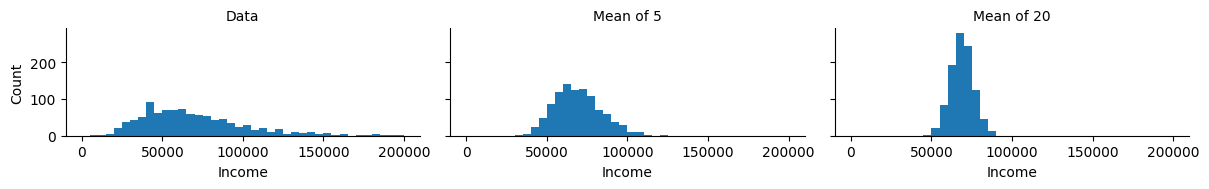

In [52]:
# sample 1000 values to get an idea of the data distribution
sample_data = pd.DataFrame({
    'income': loans_income.sample(1000)["x"],
    'type': 'Data',
})
# take 1000 samples of the mean of 5 values
sample_mean_05 = pd.DataFrame({
    'income': [loans_income.sample(5).mean()["x"] for _ in range(1000)],
    'type': 'Mean of 5',
})
# take 1000 samples of the mean of 20 values
sample_mean_20 = pd.DataFrame({
    'income': [loans_income.sample(20).mean()["x"] for _ in range(1000)],
    'type': 'Mean of 20',
})

results = pd.concat([sample_data, sample_mean_05, sample_mean_20])

g = sns.FacetGrid(results, col="type", height=2, aspect=2)
g.map(plt.hist, "income", range=[0, 200_000], bins=40)
g.set_axis_labels("Income", "Count")
g.set_titles("{col_name}")
plt.show()